In [14]:
import fastbook

fastbook.setup_book()

from fastbook import *
import matplotlib.pyplot as plt
from torch.nn import functional as F

# SGD example with a synthetic model

Gradient descent basically means that for a function `y = ax^2 + bx +c`, we will repeatedly try to find the most optimal values for `a`, `b`, and `c` so that the function is the closest possible to the actual data points. 

This is done by calculating the gradient of the function, which is the slope of the function at a given point. The gradient tells us how much we need to change the values of `a`, `b`, and `c` to make the function closer to the data points. 

The goal here is to update the values of `a`, `b`, and `c` by subtracting the gradient from them. This process is repeated until the function converges to the optimal values of `a`, `b`, and `c`. This is how _loss_ is minimized.

Gradient descent is the foundation of deep learning: it iterates over and over again to set some parameters in order to make a function match actual data. SGD mainly relies on a lot of addition and multiplication.

Imagine you were measuring the spped of a roller coaster as it goes over the top of a hump. You would expect it to be fastest at the bottom, and slowest at the top, and then it would slow up again as it goes up the other side: you want to build a model of how the speed changes over time.

In [15]:
# let's use a scenario where we measure the speed of our roller coaster every 20 seconds
measurements_times = torch.arange(0,20).float(); 
measurements_times

# `torch.arange` is a function that returns a rank-1 tensor containing a range of values within the specified range

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

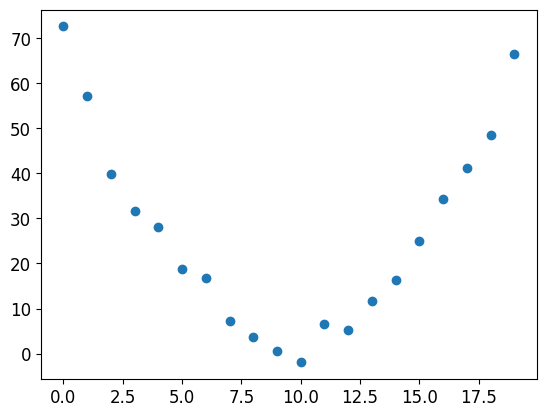

In [16]:
# let's simulate the measurements of the roller coaster's speed, we'll add some noise to the measurements,
# since these kinds of endeavors are never perfectly precise in real life
measurements_speed = torch.randn(20)*3 + 0.75*(measurements_times - 9.5)**2 + 1

plt.scatter(measurements_times, measurements_speed)

Since we've added noise, it's not that easy to answer the question: what was the roller coaster's speed at a given point ? Let's guess that the function that will give us the speed is a quadratic function, e.g. a function of the form `a*(time**2) + b*time + c`.

We want to cleary make the distinction between 2 things:

- the function's input, which is the time at which we measured the speed
- the function's parameters, which are the values `a`, `b` and `c`, e.g. the values that define _quadratic_ we're trying

Let's represent this idea in code, by separating the input from the parameters in our quadratic function signature:

In [17]:
def function_to_fit(function_input, function_params):
    a,b,c = function_params
    return a*(function_input**2) + (b*function_input) + c

What we are doing here is that we are trying to find the best imaginable function that fits the data. This is a simplification since, now, all we have to do is find the best values for `a`, `b` and `c`.

Solving this problem for 3 parameters of a quadratic function makes it possible to solve it for any number of parameters of any function.

To define what are the _best_ parameters parameters (weights) for our function, we need to define a _loss function_.

This function will return a value based on a prediction and a target. The lower the value, the better the prediction. For continuous data, it is common to use the mean squared error (MSE) loss function, which simply calculates the mean of the squared differences between the predictions and the targets.

In [18]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Let's put all this together following a 7-step process

![./7-step-process.png](./7-step-process.png)   

## Step 1: initialize the weights

In [19]:
# random values at first + telling `PyTorch` to track gradients
weights = torch.randn(3).requires_grad_()
weights

tensor([ 0.6863,  0.4679, -0.2049], requires_grad=True)

## Step 2: get some predictions

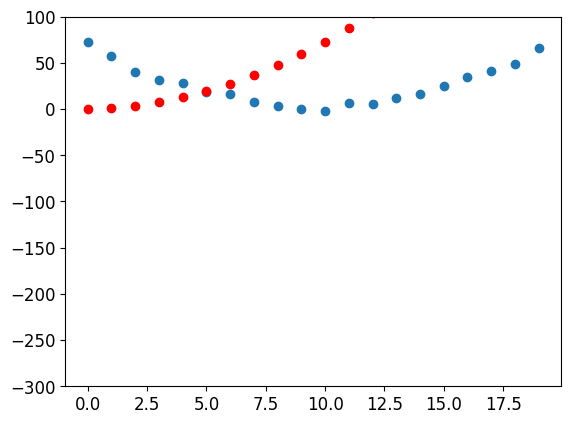

In [20]:
preds = function_to_fit(measurements_times, weights)

# function to see how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    # plotting the actual values with blue dots
    ax.scatter(measurements_times, measurements_speed)
    # plotting the predictions with red dots
    ax.scatter(measurements_times, to_np(preds), color='red')
    ax.set_ylim(-300,100)

show_preds(preds)

As you can see, our model predicts a totally different roller coaster speed than the actual one...

We can know calculate the loss to try and improve our model.

## Step 3: calculate the loss

In [21]:
loss = mse(preds, measurements_speed)
loss

tensor(10187.9268, grad_fn=<MeanBackward0>)

## Step 4: calculate the gradients

In [22]:
loss.backward()
weights.grad

tensor([32728.7188,  2100.9204,   124.9925])

In [23]:
# let's give a shot at improving our parameters by picking a learning rate;
# for now, let's use `1e-5`, or `0.00001`
weights.grad * 1e-5

tensor([0.3273, 0.0210, 0.0012])

## Step 5: step the weights

Let's update the parameters of our model using the gradients we've just calculated.

In [24]:
learning_rate = 1e-5
weights.data -= learning_rate * weights.grad.data
# we reset the gradients to zero after each step
weights.grad = None

# let's run the loss function again with the new parameters (weights)
preds = function_to_fit(measurements_times, weights)
mse(preds, measurements_speed)

tensor(2470.4714, grad_fn=<MeanBackward0>)

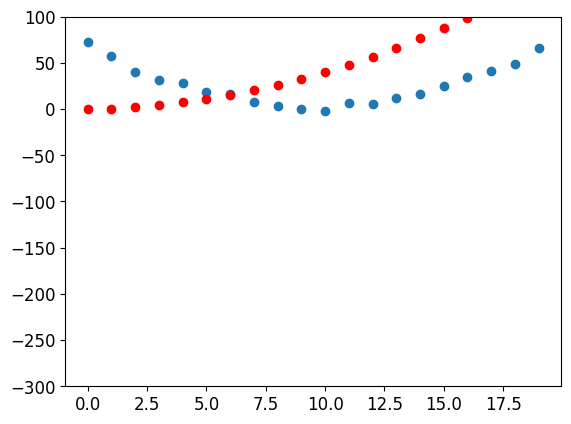

In [25]:
# let's see how our predictions look now (if our loss has improved)
show_preds(preds)

It's better, but we obviously need to repeat the process a few times.

Let's create a function for this.

In [26]:
def apply_steps_2_to_5(weights, print_loss=True):
    preds = function_to_fit(measurements_times, weights)
    loss = mse(preds, measurements_speed)
    if print_loss: print(loss)
    loss.backward()
    learning_rate = 1e-5
    weights.data -= learning_rate * weights.grad.data
    weights.grad = None
    return preds

## Step 6: repeat the process

In [27]:
for i in range(10): apply_steps_2_to_5(weights)

# we can see that the loss is decreasing, which means our predictions are getting better :)

tensor(2470.4714, grad_fn=<MeanBackward0>)
tensor(1010.0901, grad_fn=<MeanBackward0>)
tensor(733.7384, grad_fn=<MeanBackward0>)
tensor(681.4413, grad_fn=<MeanBackward0>)
tensor(671.5424, grad_fn=<MeanBackward0>)
tensor(669.6663, grad_fn=<MeanBackward0>)
tensor(669.3083, grad_fn=<MeanBackward0>)
tensor(669.2379, grad_fn=<MeanBackward0>)
tensor(669.2216, grad_fn=<MeanBackward0>)
tensor(669.2156, grad_fn=<MeanBackward0>)


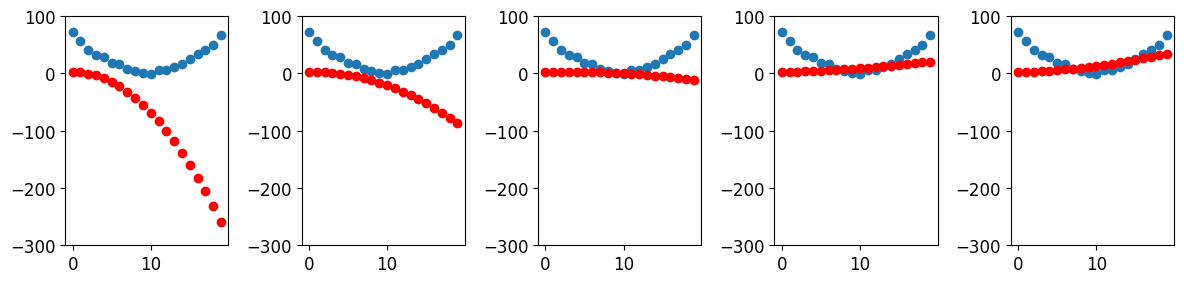

In [28]:
# for a better visual representation, let's plot the loss values
_,axs = plt.subplots(1,5,figsize=(12,3))
test_weights = torch.randn(3).requires_grad_()
for ax in axs: show_preds(apply_steps_2_to_5(test_weights, False), ax)
plt.tight_layout()

#### Step 7: stop the training process

We've decided to stop the training after 10 epochs arbitrarily. In practice, you would want to stop the training process when the model stops improving or gets worse. This means watching both training and validation loss, and stopping when the validation loss starts to increase (or at least, the rate of decrease slows down).